In [1]:
%load_ext autoreload
%autoreload 2

In [192]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import caffe
import cv2
import pandas as pd
from pandas import read_csv
import os
import skimage

%matplotlib inline

In [3]:
from utils import parse_folder, bbox, image_load, make_folder_tree
from utils import extract_filename_in_path, scaleRadius, pad_img, subsample_inner_circle_img

In [ ]:
from joblib import Parallel, delayed

In [4]:
root_folder = '/media/arya/3296EADC96EA9F99/DiabeticRetinopathy/'
run_mode = 'train_orig'

In [5]:
mode = run_mode
in_folder = os.path.join(root_folder, mode)
out_folder = '/home/arya/data/train'

In [6]:
names = parse_folder(in_folder, "jpeg")

In [179]:
del pdd, pdlab

In [180]:
pdlab = read_csv(os.path.join(root_folder, "labels.csv"), names=['image', 'label'], header=0)
pdlab.head()

,image,label
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [184]:
def sample_train_val_split(names, pdlab, valsplit):
    pdlab = pdlab.reset_index()
    counts = pd.Series(pdlab.label).value_counts()
    samples_per_label = {}
    total_num = pdlab.count()['label']
    val_idx = np.zeros(total_num, dtype=np.uint8)
    for k in counts.keys():
        samples_per_label[k] = int(round(valsplit * counts[k] / total_num))
        b = np.arange(counts[k])
        np.random.shuffle(b)
        b = b[:samples_per_label[k]]
        val_idx[pdlab.index[pdlab.label==k][b]] = 1
    pdlab['val'] = pd.Series(val_idx, index=pdlab.index)
    pdlab = pdlab.set_index('image')
    return pdlab

In [185]:
pdlab = sample_train_val_split(names, pdlab, 1500)

In [130]:
def preproc_tight_bb_crop10p(img, scale):
    """Crop the extra black region, outer 10% of 
    the retinal circle and 10 pixels from top and bottom 
    of the image.
    
    Return
        out: shape (2 * scale, 2 * scale, 3)
    """
    simg = scaleRadius(img, round(scale/.9))
    suimg = subsample_inner_circle_img(simg, round(scale/.9))
    cimg = bbox(suimg)
    pimg = pad_img(cimg, (2*scale, 2*scale, 3))
    pimg[:10, :, :] = 0
    pimg[-10:, :, :] = 0
    return pimg

/home/arya/data/train/0/29432_left.jpeg


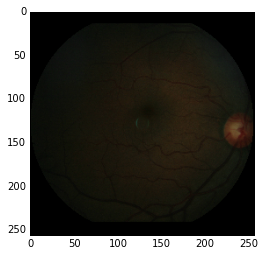

In [131]:
for n in names:
    img = image_load(n)
    pimg = preproc_tight_bb_crop10p(img, 128)
    plt.imshow(pimg)
    name_key = extract_filename_in_path(n)
    out_name = os.path.join(out_folder, "%d" % (pdlab.ix[name_key]['label']), '%s.jpeg' % name_key)
    make_folder_tree(out_name)
    print out_name
    break

## Image processing trials

In [72]:
pd.ix[pd.label==4]

,label
image,
16_left,4
16_right,4
217_left,4
217_right,4
294_left,4
294_right,4
326_left,4
326_right,4
367_left,4


In [122]:
img = image_load(os.path.join(in_folder, "1138_left.jpeg"))
plt.imshow(img);

Shape after cropping: (254, 254, 3)
Shape after padding: (256, 256, 3)


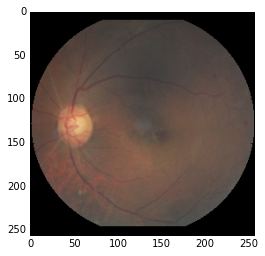

In [129]:
scale = 128
simg = scaleRadius(img, round(scale/.9))
suimg = subsample_inner_circle_img(simg, round(scale/.9))
cimg = bbox(suimg)
print "Shape after cropping:", cimg.shape
pimg = pad_img(cimg, (2*scale, 2*scale, 3))
pimg[:10, :, :] = 0
pimg[-10:, :, :] = 0
plt.imshow(pimg);
print "Shape after padding:", pimg.shape

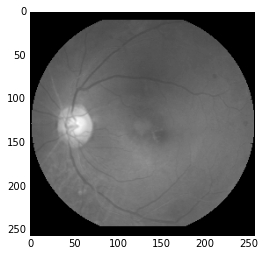

In [126]:
gimg = cv2.cvtColor(pimg, cv2.COLOR_RGB2GRAY)
plt.imshow(gimg, cmap='gray')

## Morphological BlackHat op to extract the nerves and spots

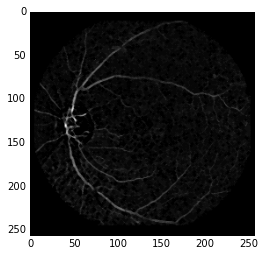

In [127]:
dimg = cv2.morphologyEx(gimg, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
timg = cv2.morphologyEx(dimg, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
timg[:, :5] = 0
timg[:, -5:] = 0
timg[:5, :] = 0
timg[-5:, :] = 0
plt.imshow(timg, cmap='gray')

## Try and extract the optic disk

In [ ]:
from skimage import exposure, img_as_float

In [ ]:
nimg = img[:,:,1]
nimg = img_as_float(nimg)
p2, p98 = np.percentile(nimg, (2, 98))
aimg = exposure.rescale_intensity(nimg, in_range=(p2, p98))
plt.imshow(aimg, cmap='gray')